# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Load the Data

In [9]:
import pandas as pd
import numpy as np
import math
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

#### Portfolio 
10 offers, 6 columns (channels, difficulty, duration, id, offer_type, reward)

In [10]:
#portfolio

In [11]:
#portfolio.info()

#### Profile
17,000 users, 5 columns (age, became_member_on, gender, id, income)

In [12]:
#profile.head()

In [13]:
#profile.info()

#### Transcript
306,534 events, 4 columns (event, person, time, value)

In [14]:
#transcript.head()

In [15]:
#transcript.info()

Portfolio and Transcript have no null values.
Profile has 2175 null values for both gender and income. 
Missing ages for profile are encoded as 118, and there are also 2175 such values.
Upon further examination, these same users are missing all three values.

In [16]:
no_demo_users = profile.loc[profile['age'] == 118].id.values

#### Gender Distribution
There are 2175 null values for age. 
Of the customers with demographic information, they are about 57% Male, 41% Female, and 1.4% Other

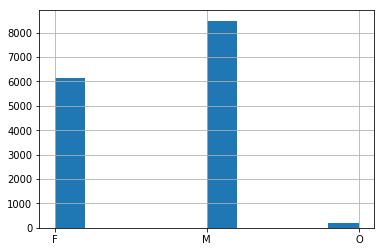

In [17]:
profile['gender'].hist();

In [18]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

#### Income distribution
Mean income is around \\$65405. 
Median income is \\$64000. 
There are 2175 null values for income. 
Income is skewed right.


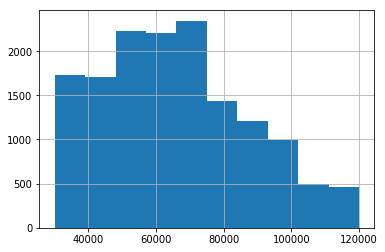

In [19]:
profile['income'].hist();

In [20]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

#### Age distribution
Mean age is about 62 years of age with a median age of 58 years. 
The mean age is skewed because users without an age value are encoded as 118. 
There are 2175 such users. 
If we remove these, there is a fairly normal distribution of ages. 
This gives a mean age of about 54 years and a median age of about 55 years. 

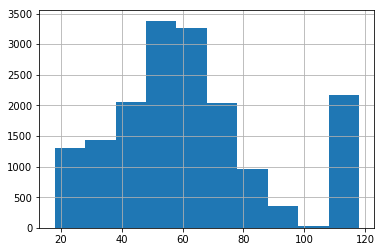

In [21]:
profile['age'].hist();

In [22]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

Age distribution excluding null values encoded as 118.

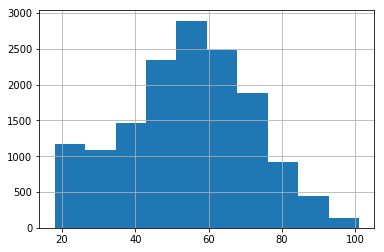

In [23]:
profile_age_clean = profile[profile['age'] < 118]['age']
profile_age_clean.hist();

In [24]:
profile_age_clean.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

#### Event distribution

This creates a dataframe which shows the counts of each event type for each user. There are 17000 total users in this dataframe.
* Sort the transcript dataframe by person.
* Get the unique event types.
* Create new dataframe with each unique person value as the index.
* For each event type: 
    * Create a dataframe of events of that event type and set person as index.
    * Set the event_name as the column name.
    * Replace the event_name value with 1.
    * Create a new dataframe with the count of the event type for each person.
    * Join the dataframe to the event_count_df.
* Fill nulls with 0.
* Return the new dataframe.

In [25]:
def create_events_df(df=transcript): 
    '''
    Description: Takes in the transcript dataframe and creates a new dataframe
    with a count of each event type for each person.
    
    Input:
    df - pandas dataframe, defaulted to transcript, the dataframe to convert
    
    Output:
    event_count_df - pandas, dataframe, contains counts of events for each person
    '''
    df.sort_values(by='person', inplace=True)
    events = df.event.unique()
    event_count_df = pd.DataFrame(index = transcript['person'].unique())
    for event_name in events: 
        event_df = df[df['event'] == event_name].set_index(['person'])
        event_df.rename(columns={'event': event_name}, inplace=True)
        event_df.replace(event_name, 1, inplace=True)
        event_df = pd.DataFrame(event_df.groupby('person')[event_name].count())     
        event_count_df = event_count_df.join(event_df)
        
    event_count_df.fillna(0, inplace=True)
        
    return event_count_df

In [26]:
event_count_df = create_events_df()

##### All Customers

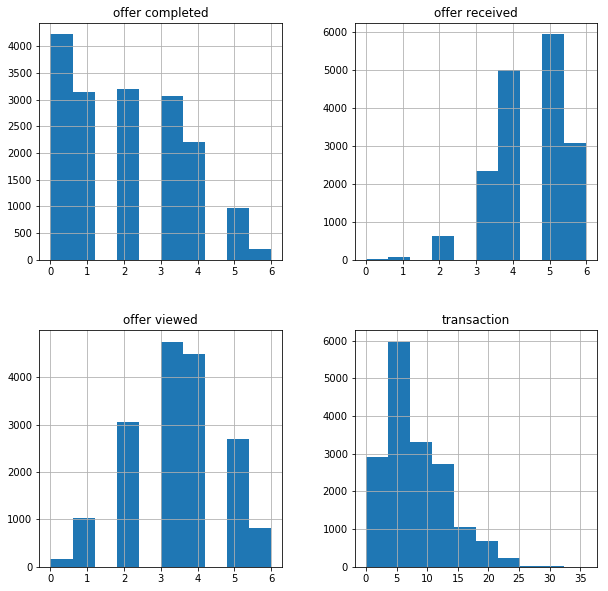

In [27]:
event_count_df.hist(figsize=(10,10));

In [28]:
event_count_df.describe()

,transaction,offer received,offer viewed,offer completed
count,17000.000000,17000.000000,17000.000000,17000.000000
mean,8.173706,4.486882,3.395588,1.975235
std,5.116250,1.076165,1.297653,1.605563
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,2.750000,1.000000
50%,7.000000,5.000000,3.000000,2.000000
75%,11.000000,5.000000,4.000000,3.000000
max,36.000000,6.000000,6.000000,6.000000


##### Customers Without Demographic Information

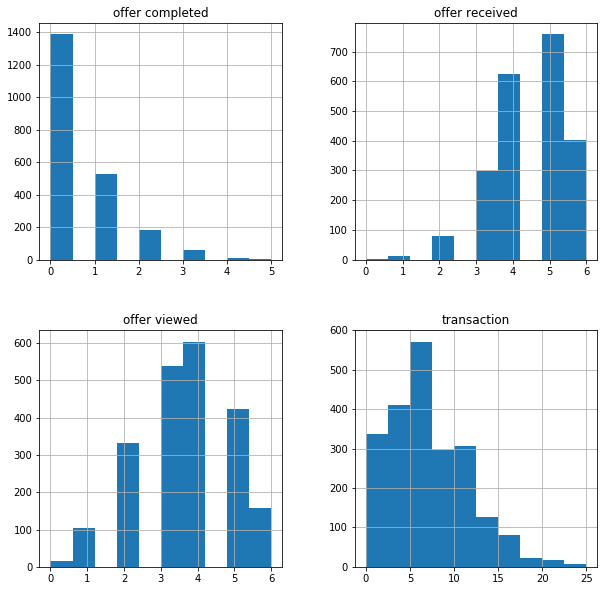

In [30]:
event_count_df.loc[no_demo_users].hist(figsize=(10,10));

In [31]:
event_count_df.loc[no_demo_users].describe()

,transaction,offer received,offer viewed,offer completed
count,2175.000000,2175.000000,2175.000000,2175.000000
mean,6.894713,4.494713,3.616092,0.521839
std,4.432510,1.086356,1.319383,0.814630
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,3.000000,0.000000
50%,6.000000,5.000000,4.000000,0.000000
75%,10.000000,5.000000,5.000000,1.000000
max,25.000000,6.000000,6.000000,5.000000


##### Customers With Demographic Information

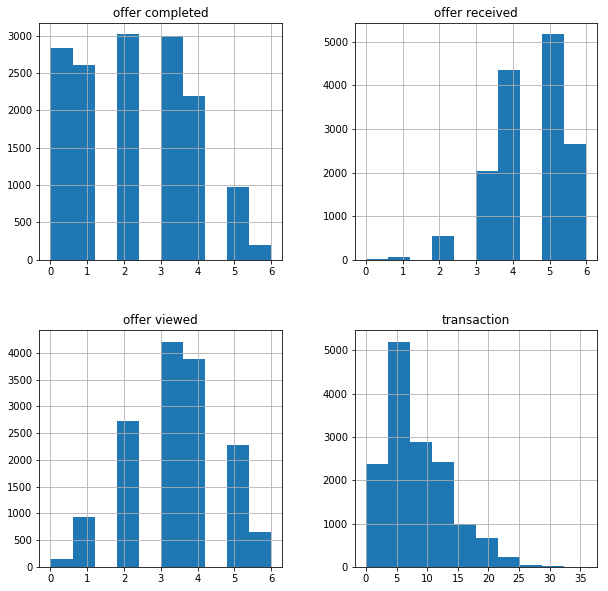

In [32]:
event_count_df.loc[~event_count_df.index.isin(no_demo_users)].hist(figsize=(10,10));

In [33]:
event_count_df.loc[~event_count_df.index.isin(no_demo_users)].describe()

,transaction,offer received,offer viewed,offer completed
count,14825.000000,14825.000000,14825.000000,14825.000000
mean,8.361349,4.485734,3.363238,2.188465
std,5.182667,1.074694,1.291316,1.582193
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,2.000000,1.000000
50%,7.000000,5.000000,3.000000,2.000000
75%,11.000000,5.000000,4.000000,3.000000
max,36.000000,6.000000,6.000000,6.000000


The customers with demographic information have a nearly identical distribution of events to the full dataset. Looking at the customers with no demographic information, the distribution for each event is also about the same as the full dataset. 

### Data Cleaning

#### Event Details
Details for each event occurring during the test period. 
* From the transcript dataframe, sort values by person and time and reset the index.
* Break out the value column in transcript to retrieve offer id, transaction amount, and reward amounts.
* Concatenate event value details and drop original values column.
* Fill nulls with 0
* Merge 'offer id' and 'offer_id' columns.
    * Fill 'offer id' nulls with values from 'offer_id'
    * Drop 'offer_id column
* Join portfolio dataframe to event_detail_df on 'offer id' to add offer details.

In [37]:
event_values_df = transcript.sort_values(by=['person', 'time']).reset_index(drop=True)

In [38]:
event_values_df_split = json_normalize(event_values_df['value'])

In [39]:
event_detail_df = pd.concat([event_values_df, event_values_df_split], axis=1).drop('value', axis=1)
event_detail_df['reward'].fillna(0, inplace=True)
event_detail_df['amount'].fillna(0, inplace=True)
event_detail_df['offer id'].fillna(event_detail_df['offer_id'], inplace=True)
event_detail_df.drop('offer_id', axis=1, inplace=True)

In [40]:
event_detail_df = event_detail_df.join(portfolio.set_index(['id']), how='left', on='offer id', rsuffix='_offer')
event_detail_df.head()

,event,person,time,amount,offer id,reward,channels,difficulty,duration,offer_type,reward_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,3.0,informational,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,336,0.00,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,0.00,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,0.0


#### Event Counts
Counts for each event type for each user. 
* Sum total amount spent per person (profit) and total reward received per person (loss)
* Set profit column to sum of amount column
* Set loss to sum of reward column

In [41]:
event_df_totals = event_detail_df.groupby(by=['person']).sum()

In [42]:
event_count_df['profit'] = event_df_totals['amount']
event_count_df['loss'] = event_df_totals['reward']
event_count_df.head()

,transaction,offer received,offer viewed,offer completed,profit,loss
0009655768c64bdeb2e877511632db8f,8.0,5.0,4.0,3.0,127.60,9.0
00116118485d4dfda04fdbaba9a87b5c,3.0,2.0,2.0,0.0,4.09,0.0
0011e0d4e6b944f998e987f904e8c1e5,5.0,5.0,5.0,3.0,79.46,13.0
0020c2b971eb4e9188eac86d93036a77,8.0,5.0,3.0,3.0,196.86,14.0
0020ccbbb6d84e358d3414a3ff76cffd,12.0,4.0,4.0,3.0,154.05,13.0


#### User-Offer Matrix
Shows counts of each offer type by user and event type
* Group event_detail_df by person, event, and offer_type, get the count of offer_type, and unstack with null values set to 0.

In [43]:
offers_by_person = event_detail_df.groupby(['person', 'event', 'offer_type'])['offer_type'].count().unstack(fill_value=0)
offers_by_person.head(20)

offer_type                                        bogo  discount  \
person                           event                             
0009655768c64bdeb2e877511632db8f offer completed     1         2   
                                 offer received      1         2   
                                 offer viewed        1         1   
00116118485d4dfda04fdbaba9a87b5c offer received      2         0   
                                 offer viewed        2         0   
0011e0d4e6b944f998e987f904e8c1e5 offer completed     1         2   
                                 offer received      1         2   
                                 offer viewed        1         2   
0020c2b971eb4e9188eac86d93036a77 offer completed     1         2   
                                 offer received      2         2   
                                 offer viewed        1         1   
0020ccbbb6d84e358d3414a3ff76cffd offer completed     2         1   
                                 offer received      2         1   
                                 offer viewed        2         1   
003d66b6608740288d6cc97a6903f4f0 offer completed     0         3   
                                 offer received      0         3   
                                 offer viewed        0         2   
00426fe3ffde4c6b9cb9ad6d077a13ea offer completed     0         1   
                                 offer received      0         4   
                                 offer viewed        0         1   

offer_type                                        informational  
person                           event                           
0009655768c64bdeb2e877511632db8f offer completed              0  
                                 offer received               2  
                                 offer viewed                 2  
00116118485d4dfda04fdbaba9a87b5c offer received               0  
                                 offer viewed                 0  
0011e0d4e6b944f998e987f904e8c1e5 offer completed              0  
                                 offer received               2  
                                 offer viewed                 2  
0020c2b971eb4e9188eac86d93036a77 offer completed              0  
                                 offer received               1  
                                 offer viewed                 1  
0020ccbbb6d84e358d3414a3ff76cffd offer completed              0  
                                 offer received               1  
                                 offer viewed                 1  
003d66b6608740288d6cc97a6903f4f0 offer completed              0  
                                 offer received               2  
                                 offer viewed                 2  
00426fe3ffde4c6b9cb9ad6d077a13ea offer completed              0  
                                 offer received               1  
                                 offer viewed                 1

### Make Recommendations

Find users with similar demographic information to the input user.
* Get the user from the profile dataset
* Get the user's age, gender, and income
* Filter the dataframe by user's gender and specified age and income ranges. 
* Return ids of the similar users. 

In [44]:
def find_similar_users(user, age_dif=10, income_dif=10000, user_df=profile):
    '''
    Description: Takes in a user and finds other users with similar demographic information.
    
    Input:
    user - string, the user to compare
    age_dif - numeric, the maximum age difference between the user and other members. Defaults to 10 years. 
    income_dif - numeric, the maximum income difference in between the user and other members. Defaults to $10,000.
    user_df - pandas dataframe, contains demographic information about all the users. Defaults to profile.
    
    Output:
    similar_users - array, users simililar to the provided user
    '''
    
    user_info = profile[profile['id'] == user]
    age = user_info['age'].values[0]
    gender = user_info['gender'].values[0]
    income = user_info['income'].values[0]
    similar_users = profile[(profile['age'] >= (age - age_dif)) & (profile['age'] <= (age + age_dif)) & 
       (profile['gender'] == gender) &
       ((profile['income'] >= (income - income_dif)) & (profile['income'] <= (income + income_dif)))]['id'].values
    
    return similar_users

Create a group from specified demographic information
* Filter the dataframe by the specified age range, gender(s), and income range. 
* Return array of ids for users meeting the specifications.

In [45]:
def create_user_group(age=[0, 118], gender=['M', 'F', 'O'], income=[0, 999999999], user_df=profile):
    '''
    Description: Takes in demographic information and outputs a list of users meeting those demographic specifications.
    
    Input:
    age - array of two numeric values, the minimum and maximum ages for the user group. Defaults to range 0-118. 
    gender - array of single character strings, the genders for the user group. 'M' for male, 'F' for female, 'O' for other
        or non-binary. Defaults to all three. 
    income - numeric, the minimum and maximum incomesfor the user group. Defaults to range $0 to $999,999,999.
    user_df - pandas dataframe, contains demographic information about all the users. Defaults to profile.
    
    Output:
    users - array, users meeting the provided demographic information
    '''
    users = profile[(profile['age'] >= (age[0])) & (profile['age'] <= (age[1])) & 
           (profile['gender'].isin(gender)) &
           ((profile['income'] >= (income[0])) & (profile['income'] <= (income[1])))]['id'].values
    return users

Create recommendations for a group of users. 
* For each user in the group, get the information from the user_matrix and the user_count dataframes.
* Get completed offers and viewed offers for the user for each offer type. Set to 0 if none exist. 
* Calculate weighted value of each offer type by 1 minus the absolute value of the difference between completed offers and viewed offers divided by the received offers. 
* Add each weight to the total weight for the offer type. 
* Sort the offer types by weight
* Return the sorted array and a dictionary of the offers and their weights. 

In [46]:
def recommend_group_offers(group, df_count=event_count_df, df_detail=event_detail_df, user_matrix=offers_by_person):
    '''
    Description:
    Sorts the offer types by how well a given group responds to the offer. 
    
    Input:
    group - array, 
    df_count - pandas dataframe, contains event interaction counts for each customer. 
    df_detail - pandas dataframe, contains details about the events that have occurred. 
    user_matrix - pandas dataframe, shoes the count of customer interactions for each offer type.
    
    Output: 
    top_offers - array, the array of offer types sorted by best response. Does not include ineffective offers.
        If no offers are effective, contains a string stating such. 
    offer_weights - dictionary, the weights for each ofer type. 
    '''
    bogo_weight = 0
    discount_weight = 0
    info_weight = 0
    
    top_offers = []
    
    for user in group:
        try:
            user_df = user_matrix.loc[user]
            user_count = df_count.loc[user]
            
            counts = user_count.values
            transactions, received, viewed, completed, profit, loss = counts[range(len(counts))]

            if completed > 0:
                completed_offers = user_df.loc['offer completed'].values
            else:
                completed_offers = [0, 0, 0]

            if viewed > 0:
                viewed_offers = user_df.loc['offer viewed'].values
            else:
                viewed_offers = [0, 0, 0]

            bogo_weight += (1 - (abs(viewed_offers[0] - completed_offers[0])) / received)
            discount_weight += (abs((viewed_offers[1] - completed_offers[1])) / received)
            info_weight += (abs((viewed_offers[2] - completed_offers[2])) / received)
            
        except:
            continue
    
    offer_weights = {'bogo': bogo_weight, 'discount': discount_weight, 'information': info_weight}
    top_offers = sorted(offer_weights, key=offer_weights.get, reverse=True)
    
    
    return top_offers, offer_weights

### Evaluate Results
Calculate the root mean squared error to check accuracy of recommendations
* Create a dictionary to map each offer type to a number.
* Create a prediction array mapping each offer type in the recommendation array to the dictionary. 
* Find squared error for each user and append it to errors array.
* Find the mean of the errors array. 
* Return the square root of the mean squared error. 

In [47]:
def check_recommendation_accuracy(group, recommendation): 
    '''
    Description: Checks the accuracy of the recommendations by checking the group prediction against each user. 
    Input:
    group - array, the ids for the users in the recommendation group.
    recommendation - array, the sorted array with the offer types in order of recommendation. 
    
    Output: 
    rmse - float, the root mean squared error for the recommendations. 
    
    '''
    offer_dict = {'bogo': 1, 'discount': 2, 'information': 3}
    pred = []
    errors = []
    for offer in recommendation:
        pred.append(offer_dict[offer])
    
    for user in group:
        actual = []
        
        for offer in recommend_group_offers([user])[0]:
            actual.append(offer_dict[offer])
            
        sq_error = np.sum((pd.Series(actual) - pd.Series(pred)) **2)
        errors.append(sq_error)
        
    mean_sq_error = pd.Series(errors).mean()
    rmse = math.sqrt(mean_sq_error)
    
    return rmse

### Examples

No demographic info from list created before. 

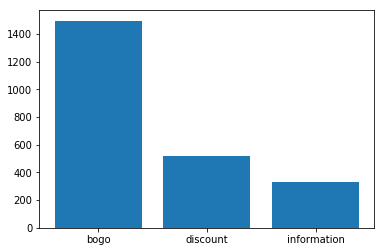

In [48]:
recs, offers = recommend_group_offers(no_demo_users)
plt.bar(offers.keys(), offers.values());

In [49]:
check_recommendation_accuracy(no_demo_users, recs)

0.7258764025122583

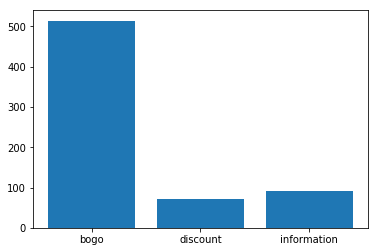

In [50]:
sim_group = find_similar_users('0009655768c64bdeb2e877511632db8f')
recs, offers = recommend_group_offers(sim_group)
plt.bar(offers.keys(), offers.values());

In [51]:
check_recommendation_accuracy(sim_group, recs)

1.1551623262554922

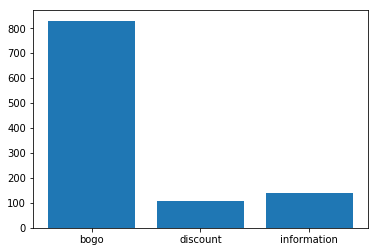

In [52]:
sim_group2 = find_similar_users('0020ccbbb6d84e358d3414a3ff76cffd', 20, 20000)
recs, offers = recommend_group_offers(sim_group2)
plt.bar(offers.keys(), offers.values());

In [53]:
check_recommendation_accuracy(sim_group2, recs)

1.1236102527122116

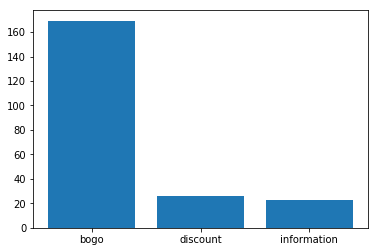

In [54]:
new_group = create_user_group([20,30], ['F'], [50000, 70000])
recs, offers = recommend_group_offers(new_group)
plt.bar(offers.keys(), offers.values());

In [55]:
check_recommendation_accuracy(new_group, recs)

0.7893767021450832